# Advanced Urothelial Carcinoma Survival
## 1. Cohort Creation

### 1.1 Inclusion-exclusion criteria
#### a) Inclusion: patients diagnosed with advanced urothelial cancinoma between 01/01/2011 and 12/01/2021

In [1]:
setwd("~/Library/CloudStorage/Box-Box/RWD/BladderCancerSurvival/BladderCancerSurvival/")
eauc <- read.csv("../Bladder/Enhanced_AdvUrothelial.csv")
eauc$AdvancedDiagnosisDate <- as.Date(eauc$AdvancedDiagnosisDate)

ptid <- subset(eauc, subset = AdvancedDiagnosisDate >= as.Date("2011-01-01") & 
                              AdvancedDiagnosisDate <= as.Date("2021-12-01"))$PatientID
length(ptid)

[1] 11276

#### b) Exclude patients who have received clinical study drug

In [2]:
source("lineoftherapy.R")
# # line of therapy also starts 2011-01
# min(lineoftherapy$StartDate)

# total treatment types -- 541
unique.therapy <- unique(lineoftherapy$LineName)
# (length(unique.therapy))

# remove Patients receiving therapy in the context of a clinical study
## Clinical Study Drug
csd <- unique.therapy[grep("Clinical", unique.therapy)]
ptid.csd <- unique(subset(lineoftherapy, LineName %in% csd)$PatientID)

ptid <- setdiff(ptid, ptid.csd)
length(ptid)

[1] 10742

#### c) Exclude untreated patients


In [3]:
ptid.treated <- unique(lineoftherapy$PatientID)
ptid <- intersect(ptid, ptid.treated)

# 7429 after removing untreated patients
length(ptid)

[1] 7429

### 1.2 Find study endpoint
Event: death; censor: the latest of Visit, Enhanced_AdvUrothelial_Orals and DrugEpisode and AdvancedDiagnosisDate itself.

In [4]:
source("oral.R")
source("visit.R")
source("drugepisode.R")
source("mortality.R")

dd <- subset(eauc,
             PatientID %in% ptid,
             select = c(PatientID, AdvancedDiagnosisDate, PrimarySite,
                        GroupStage, SmokingStatus, Surgery))

dd <- merge(dd, mortality, all.x = TRUE)

dd$Death <- !is.na(dd$DateOfDeath)

pt.censored <- dd$PatientID[!dd$Death]

for (pp in pt.censored) {
  date.oral <- oral$StartDate[oral$PatientID == pp]
  date.visit <- visit$VisitDate[visit$PatientID == pp]
  date.episode <- drugepisode$EpisodeDate[drugepisode$PatientID == pp]
  date.advdiagnosis <- dd$AdvancedDiagnosisDate[dd$PatientID == pp]
  censored.date <- max(c(date.oral, date.visit, date.episode, date.advdiagnosis))
  dd$DateOfDeath[dd$PatientID == pp] <- censored.date
}

names(dd)[ncol(dd) - 1] <- "DeathCensorDate"

### 1.3 Define three cohorts by diagnosis date

In [5]:
dd$DiagnosisPeriod <- ifelse(dd$AdvancedDiagnosisDate < as.Date("2016-05-18"),
                             "Before ICI", ifelse(dd$AdvancedDiagnosisDate > as.Date("2019-12-18"),
                                                  "After ADC",
                                                  "Between ICI & ADC"))

dd$DiagnosisPeriod <- factor(dd$DiagnosisPeriod, levels = c("Before ICI", "Between ICI & ADC", "After ADC"))

In [6]:
head(dd)

,PatientID,AdvancedDiagnosisDate,PrimarySite,GroupStage,SmokingStatus,Surgery,DeathCensorDate,Death,DiagnosisPeriod
,<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<date>,<lgl>,<fct>
1,F001E5D4C6FA0,2013-03-20,Bladder,Unknown/not documented,History of smoking,true,2014-02-15,TRUE,Before ICI
2,F0025BA658AE1,2018-12-26,Bladder,Unknown/not documented,History of smoking,false,2023-06-27,FALSE,Between ICI & ADC
3,F00284BE233DB,2019-01-28,Bladder,Stage IV,History of smoking,false,2019-09-15,TRUE,Between ICI & ADC
4,F00287E47602D,2019-09-17,Bladder,Stage IVB,History of smoking,false,2022-10-15,TRUE,Between ICI & ADC
5,F0029F9C68879,2021-02-26,Bladder,Stage II,History of smoking,false,2023-06-27,FALSE,After ADC
6,F002D6142B758,2019-12-18,Renal Pelvis,Stage IVB,No history of smoking,false,2020-02-15,TRUE,Between ICI & ADC


### 1.4 Merge other information

In [7]:
library(dplyr)
# merge other information
source("demographics.R")
demo <- subset(demographics, select = c("PatientID", "BirthYear", "Gender", "Race", "Location"))

dd <- merge(dd, demo, all.x = TRUE)

dd$AdvancedDiagnosisYear <- as.integer(format(dd$AdvancedDiagnosisDate,"%Y"))

dd$AgeAtDiagnosis <- dd$AdvancedDiagnosisYear - dd$BirthYear
# summary(dd$AgeAtDiagnosis)

dd$Gender <- factor(dd$Gender)
dd$Race <- factor(dd$Race)
dd$Location <- factor(dd$Location)

dd$StageAtDiagnosis <- NA
for (i in 1:nrow(dd)) {
  if (dd$GroupStage[i] %in% c("Stage 0a", "Stage 0is")) dd$StageAtDiagnosis[i] <- "Stage0"
  if (dd$GroupStage[i] %in% c("Stage I")) dd$StageAtDiagnosis[i] <- "Stage1"
  if (dd$GroupStage[i] %in% c("Stage II")) dd$StageAtDiagnosis[i] <- "Stage2"
  if (dd$GroupStage[i] %in% c("Stage III", "Stage IIIA", "Stage IIIB")) dd$StageAtDiagnosis[i] <- "Stage3"
  if (dd$GroupStage[i] %in% c("Stage IV", "Stage IVA", "Stage IVB")) dd$StageAtDiagnosis[i] <- "Stage4"
}
dd$StageAtDiagnosis <- factor(dd$StageAtDiagnosis)
dd <- subset(dd, select = -GroupStage)

dd$SmokingHistory <- NA
dd$SmokingHistory <- ifelse(dd$SmokingStatus == "History of smoking", TRUE, FALSE)
dd <- subset(dd, select = -SmokingStatus)

dd$PrimarySite <- factor(dd$PrimarySite)

# practice type -- ever treated in academic
source("practice.R")
prac.type <- character(length(unique(practice$PatientID)))

prac <- data.frame(PatientID = unique(practice$PatientID),
                   PracticeType = prac.type)

for (i in 1:length(unique(practice$PatientID))) {
  id.tmp <- prac$PatientID[i]
  types <- subset(practice, PatientID == id.tmp)$PracticeType
  if (any(types == "ACADEMIC")) {
    prac$PracticeType[i] <- "ACEDEMIC"
  } else {
    prac$PracticeType[i] <- "COMMUNITY"
  }
}

dd <- merge(dd, prac, all.x = TRUE)
dd$PracticeType <- factor(dd$PracticeType)


# source("drugepisode.R")
drugepi <- drugepisode %>%
  inner_join(dd, by = "PatientID") %>%
  filter(LineStartDate >= AdvancedDiagnosisDate)
dd$Chemotherapy <- dd$Immunotherapy <- dd$AntibodyConjugate <- FALSE

for (i in 1:nrow(dd)) {
  idtmp <- dd$PatientID[i]
  drugname.tmp <- subset(drugepisode, PatientID == idtmp)$DrugName
  drugcategory.tmp <- subset(drugepisode, PatientID == idtmp)$DetailedDrugCategory
  
  if (any(drugcategory.tmp == "chemotherapy")) {
    dd$Chemotherapy[i] <- TRUE
  }
  
  if (any(drugname.tmp %in% c("pembrolizumab", "avelumab", "atezolizumab", "nivolumab", "durvalumab"))) {
    dd$Immunotherapy[i] <- TRUE
  }
  
  if (any(drugname.tmp %in% c("enfortumab vedotin-ejfv", "sacituzumab govitecan-hziy"))) {
    dd$AntibodyConjugate[i] <- TRUE
  }
}

# sdoh
source("sdoh.R")
dd <- merge(dd, sdoh, all.x = TRUE)

# biomarker (fgfr, pdl1 mutation)
source("biomarker.R")
bm <- subset(biomarker, PatientID %in% dd$PatientID)
bm <- subset(bm, !BiomarkerStatus %in% c("No interpretation given in report",
                                         "Unknown",
                                         "Unsuccessful/indeterminate test",
                                         "Results pending",
                                         "PD-L1 equivocal"))
pdl1 <- subset(bm, BiomarkerName == "PDL1")
fgfr <- subset(bm, BiomarkerName == "FGFR")

pdl1$PDL1 <- ifelse(pdl1$BiomarkerStatus == "PD-L1 positive", TRUE, FALSE)
fgfr$FGFR <- ifelse(fgfr$BiomarkerStatus == "Positive", TRUE, FALSE)

## multiple records for some patients
## if there are both positive and negative, set to positive
## interpretation: ever positive during followup
pdl1.unique <- unique(pdl1$PatientID)
for (pt in pdl1.unique) {
  pdl1.tmp <- subset(pdl1, PatientID == pt)
  results <- pdl1.tmp$PDL1
  if (length(unique(results)) != 1) pdl1[pdl1$PatientID == pt, "PDL1"] <- TRUE
}
pdl1 <- pdl1[, c("PatientID", "PDL1")]

fgfr.unique <- unique(fgfr$PatientID)
for (pt in fgfr.unique) {
  fgfr.tmp <- subset(fgfr, PatientID == pt)
  results <- fgfr.tmp$FGFR
  if (length(unique(results)) != 1) fgfr[fgfr$PatientID == pt, "FGFR"] <- TRUE
}
fgfr <- fgfr[, c("PatientID", "FGFR")]

pdl1 <- pdl1[!duplicated(pdl1), ]
fgfr <- fgfr[!duplicated(fgfr), ]

dd <- merge(dd, pdl1, all.x = TRUE)
dd <- merge(dd, fgfr, all.x = TRUE)

# comorbidity needs attention
# Elixhauser comorbidity
source("diagnosis.R")

# use baseline comorbidity (before advanced diagnosis date) and remove urothelial cancer
# dx <- subset(diagnosis, DiagnosisCodeSystem == "ICD-10-CM")
# dx <- subset(dx, PatientID %in% ptid)
# dx <- subset(dx, !is.na(dx$DiagnosisDate))
#
# icd10.all <- unique(dx$DiagnosisCode)
# icd10.cancer <- icd10.all[regexpr("C", icd10.all) == 1]
# icd10.uc <- c(icd10.cancer[grep("C67", icd10.cancer)],
#               icd10.cancer[grep("C65", icd10.cancer)],
#               icd10.cancer[grep("C66", icd10.cancer)],
#               "C68.0")
# dx <- subset(dx, !DiagnosisCode %in% icd10.uc)
#
# dx.before.index <- logical(nrow(dx))
# for (i in 1:nrow(dx)) {
#   row.tmp <- dx[i, ]
#   adv.dx.date <- subset(dd, PatientID == row.tmp$PatientID)$AdvancedDiagnosisDate
#   if (row.tmp$DiagnosisDate < adv.dx.date) {
#     dx.before.index[i] <- TRUE
#   } else {
#     dx.before.index[i] <- FALSE
#   }
# }
# dx <- dx[dx.before.index, ]

dx <- diagnosis %>%
  inner_join(dd, by = "PatientID") %>%
  filter(DiagnosisDate <= AdvancedDiagnosisDate)

icd10.all <- unique(dx$DiagnosisCode)
icd10.cancer <- icd10.all[regexpr("C", icd10.all) == 1]
icd10.uc <- c(icd10.cancer[grep("C67", icd10.cancer)],
              icd10.cancer[grep("C65", icd10.cancer)],
              icd10.cancer[grep("C66", icd10.cancer)],
              "C68.0")
dx <- subset(dx, !DiagnosisCode %in% icd10.uc)

library(comorbidity)

icd10 <- dx[, c("PatientID", "DiagnosisCode")]
icd10 <- icd10[complete.cases(icd10), ]

icd10$DiagnosisCode <- gsub("\\.", "", icd10$DiagnosisCode)

elix <- comorbidity(icd10,
                    "PatientID",
                    "DiagnosisCode",
                    map = "elixhauser_icd10_quan",
                    assign0 = TRUE)
elix.score <- score(elix, assign0 = TRUE)
elix.score <- data.frame(PatientID = elix$PatientID, Elixhauser = elix.score)

# # then use ICD9 for chose with missingness
# icd9 <- subset(diagnosis, DiagnosisCodeSystem == "ICD-9-CM")
#
# icd9 <- icd9[, c("PatientID", "DiagnosisCode")]
# icd9 <- icd9[complete.cases(icd9), ]
#
# icd9$DiagnosisCode <- gsub("\\.", "", icd9$DiagnosisCode)
#
# elix <- comorbidity(icd9,
#                     "PatientID",
#                     "DiagnosisCode",
#                     map = "elixhauser_icd9_quan",
#                     assign0 = TRUE)
# elix.score.9 <- score(elix, assign0 = TRUE)
#
# elix.score.9 <- data.frame(PatientID = elix$PatientID, Elixhauser = elix.score.9)
#
# use9 <- setdiff(elix.score.9$PatientID, elix.score.10$PatientID)
#
# elix.score <- rbind(elix.score.10,
#                     subset(elix.score.9, PatientID %in% use9))


dd <- merge(dd, elix.score, all.x = TRUE)
# end of comorbidity

# # add lines of treatment received
# lot <- subset(lineoftherapy, PatientID %in% ptid)
# no.lines <- aggregate(LineNumber ~ PatientID, FUN = max, data = lot)
# dd <- merge(dd, no.lines, all.x = TRUE)

# add ecog at diagnosis
source("ecog.R")
library(dplyr)
# multiple ecog value on the same day for some patients
ecog.unique <- aggregate(EcogValue ~ PatientID + EcogDate, data = ecog, FUN = max)

dd <- dd |>
  left_join(ecog.unique, join_by(PatientID == PatientID, closest(AdvancedDiagnosisDate > EcogDate))) # %>%
# Filter the rows where the diagnosis date is within the insurance coverage period
# filter(EcogDate < AdvancedDiagnosisDate)

# add insurance at diagnosis
# last one prior to advanced diagnosis date
source("insurance.R")
# multiple insurance on the same day for some patients
ins <- insurance[, c("PatientID", "PayerCategory", "StartDate")]
ins$Insurance <- ifelse(ins$PayerCategory %in% c("Medicaid", "Medicare", "Other Government Program"),
                        "Government",
                        ifelse(ins$PayerCategory %in% c("Commercial Health Plan"), "Commercial", "Other"))
ins$Insurance <- factor(ins$Insurance, levels = c("Government", "Commercial", "Other"))
ins <- subset(ins, select = -PayerCategory)
# multiple insurance with the same start date
ins <- unique(ins)
ins <- aggregate(Insurance ~ PatientID + StartDate,
                 data = ins,
                 FUN = function(x) {names(which.max(table(x)))})

dd <- dd |>
  left_join(select(ins, c(PatientID, StartDate, Insurance)),
            join_by(PatientID == PatientID, closest(AdvancedDiagnosisDate > StartDate)))

summary(dd)
dd$Insurance <- factor(dd$Insurance)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in FUN(newX[, i], ...):
“no non-missing arguments, returning NA”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments, returning NA”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments, returning NA”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments, returning NA”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments, returning NA”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments, returning NA”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments, returning NA”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments, returning NA”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments, returning NA”
Warning message in FUN(newX[, i], ...):
“no non-missing arguments, ret

  PatientID         AdvancedDiagnosisDate       PrimarySite  
 Length:7429        Min.   :2011-01-01    Bladder     :5749  
 Class :character   1st Qu.:2015-01-14    Renal Pelvis: 967  
 Mode  :character   Median :2017-07-12    Ureter      : 647  
                    Mean   :2017-04-03    Urethra     :  66  
                    3rd Qu.:2019-10-08                       
                    Max.   :2021-12-01                       
                                                             
   Surgery          DeathCensorDate        Death        
 Length:7429        Min.   :2011-03-15   Mode :logical  
 Class :character   1st Qu.:2016-08-15   FALSE:2003     
 Mode  :character   Median :2019-05-15   TRUE :5426     
                    Mean   :2019-01-11                  
                    3rd Qu.:2021-10-15                  
                    Max.   :2023-06-30                  
                                                        
          DiagnosisPeriod   BirthYear     Gender

In [8]:
dd$Surgery <- as.logical(dd$Surgery)
head(dd)

,PatientID,AdvancedDiagnosisDate,PrimarySite,Surgery,DeathCensorDate,Death,DiagnosisPeriod,BirthYear,Gender,Race,⋯,Immunotherapy,Chemotherapy,SESIndex2015_2019,PDL1,FGFR,Elixhauser,EcogDate,EcogValue,StartDate,Insurance
,<chr>,<date>,<fct>,<lgl>,<date>,<lgl>,<fct>,<int>,<fct>,<fct>,⋯,<lgl>,<lgl>,<fct>,<lgl>,<lgl>,<dbl>,<date>,<int>,<date>,<fct>
1,F001E5D4C6FA0,2013-03-20,Bladder,TRUE,2014-02-15,TRUE,Before ICI,1936,M,NA,⋯,FALSE,TRUE,4,NA,NA,NA,NA,NA,NA,NA
2,F0025BA658AE1,2018-12-26,Bladder,FALSE,2023-06-27,FALSE,Between ICI & ADC,1938,M,White,⋯,TRUE,FALSE,3,FALSE,FALSE,2,NA,NA,2014-02-01,Commercial
3,F00284BE233DB,2019-01-28,Bladder,FALSE,2019-09-15,TRUE,Between ICI & ADC,1940,M,NA,⋯,FALSE,TRUE,4,NA,NA,NA,NA,NA,2011-01-01,Commercial
4,F00287E47602D,2019-09-17,Bladder,FALSE,2022-10-15,TRUE,Between ICI & ADC,1940,M,NA,⋯,FALSE,FALSE,3,TRUE,NA,NA,NA,NA,2013-01-01,Commercial
5,F0029F9C68879,2021-02-26,Bladder,FALSE,2023-06-27,FALSE,After ADC,1954,M,White,⋯,TRUE,FALSE,NA,NA,NA,2,2021-02-24,1,2021-01-01,Commercial
6,F002D6142B758,2019-12-18,Renal Pelvis,FALSE,2020-02-15,TRUE,Between ICI & ADC,1944,M,White,⋯,FALSE,TRUE,NA,NA,TRUE,NA,NA,NA,2019-12-01,Commercial


## 2. Descriptive statistics

In [9]:
# table 1
library(table1)

pvalue <- function(x, ...) {
  # Construct vectors of data y, and groups (strata) g
  y <- unlist(x)
  g <- factor(rep(1:length(x), times=sapply(x, length)))
  if (is.numeric(y)) {
    # For numeric variables, perform a standard 2-sample t-test
    p <- summary(aov(y ~ g))[[1]]$`Pr(>F)`[1]
  } else {
    # For categorical variables, perform a chi-squared test of independence
    p <- chisq.test(table(y, g))$p.value
  }
  # Format the p-value, using an HTML entity for the less-than sign.
  # The initial empty string places the output on the line below the variable label.
  c("", sub("<", "&lt;", format.pval(p, digits=3, eps=0.001)))
}

as.data.frame(table1(~ Gender + Race + StageAtDiagnosis + AgeAtDiagnosis + EcogValue +
         SmokingHistory + Location + Insurance + PracticeType + PrimarySite +
         Surgery + PDL1 + FGFR + Elixhauser + 
         Chemotherapy + Immunotherapy + AntibodyConjugate +
         SESIndex2015_2019 | DiagnosisPeriod,
       # data = subset(dd, DiagnosisPeriod %in% c("Before ICI", "After ADC")),
       data = dd,
       overall = FALSE,
       extra.col = list(`P-value` = pvalue)))




Attaching package: ‘table1’


The following objects are masked from ‘package:base’:

    units, units<-




,Before ICI,Between ICI & ADC,After ADC,P-value
<chr>,<chr>,<chr>,<chr>,<chr>
,(N=2792),(N=2945),(N=1692),
Gender,,,,
F,714 (25.6%),774 (26.3%),495 (29.3%),0.0215
M,2077 (74.4%),2170 (73.7%),1197 (70.7%),
Missing,1 (0.0%),1 (0.0%),0 (0%),
Race,,,,
Black or African American,136 (4.9%),142 (4.8%),75 (4.4%),&lt;0.001
Other Race,395 (14.1%),506 (17.2%),293 (17.3%),
White,2086 (74.7%),2039 (69.2%),1113 (65.8%),


## 3. Crude analysis
### 3.1 Crude median OS

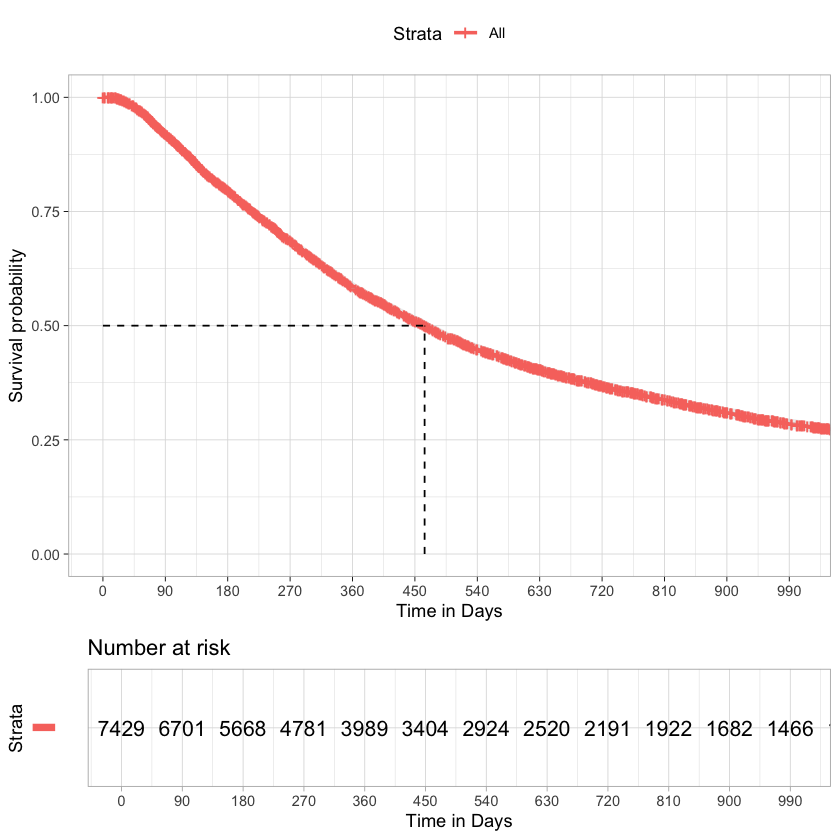

In [43]:
library(survival)
library(ggplot2)
library(survminer)
surv.dd <- with(dd, Surv(time = as.numeric(DeathCensorDate - AdvancedDiagnosisDate),
                         event = Death))

fit1 <- survfit(surv.dd ~ 1)
ggsurvplot(fit1,
           data = dd,
           conf.int = TRUE,
           surv.median.line = c("hv"),
           risk.table = TRUE,
           break.time.by = 90,
           xlim = c(0, 1000),
           ggtheme = theme_light(),
           risk.table.y.text.col = TRUE, # colour risk table text annotations.
           risk.table.y.text = FALSE,
           xlab = "Time in Days")

### 3.2 Crude OS by diagnosis cohort

In [46]:
fit2 <- survfit(surv.dd ~ dd$DiagnosisPeriod)
print(fit2)

Call: survfit(formula = surv.dd ~ dd$DiagnosisPeriod)

                                        n events median 0.95LCL 0.95UCL
dd$DiagnosisPeriod=Before ICI        2792   2207    488     469     512
dd$DiagnosisPeriod=Between ICI & ADC 2945   2182    427     408     456
dd$DiagnosisPeriod=After ADC         1692   1037    483     437     520


### 3.3 Crude RMST by diagnosis cohort

In [47]:
print(fit2, rmean = 365)
print(fit2, rmean = 365 * 2)

Call: survfit(formula = surv.dd ~ dd$DiagnosisPeriod)

                                        n events rmean* se(rmean) median
dd$DiagnosisPeriod=Before ICI        2792   2207    302      1.89    488
dd$DiagnosisPeriod=Between ICI & ADC 2945   2182    284      2.06    427
dd$DiagnosisPeriod=After ADC         1692   1037    287      2.73    483
                                     0.95LCL 0.95UCL
dd$DiagnosisPeriod=Before ICI            469     512
dd$DiagnosisPeriod=Between ICI & ADC     408     456
dd$DiagnosisPeriod=After ADC             437     520
    * restricted mean with upper limit =  365 
Call: survfit(formula = surv.dd ~ dd$DiagnosisPeriod)

                                        n events rmean* se(rmean) median
dd$DiagnosisPeriod=Before ICI        2792   2207    471      4.71    488
dd$DiagnosisPeriod=Between ICI & ADC 2945   2182    443      4.87    427
dd$DiagnosisPeriod=After ADC         1692   1037    458      6.51    483
                                     0.95LCL 0.

Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
"All aesthetics have length 1, but the data has 3 rows.
i Please consider using `annotate()` or provide this layer with data containing
  a single row."
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
"All aesthetics have length 1, but the data has 3 rows.
i Please consider using `annotate()` or provide this layer with data containing
  a single row."
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
"All aesthetics have length 1, but the data has 3 rows.
i Please consider using `annotate()` or provide this layer with data containing
  a single row."
Warning message in geom_segment(aes(x = 0, y = max(y2), xend = max(x1), yend = max(y2)), :
"All aesthetics have length 1, but the data has 3 rows.
i Please consider using `annotate()` or provide this layer with data containing
  a single row."


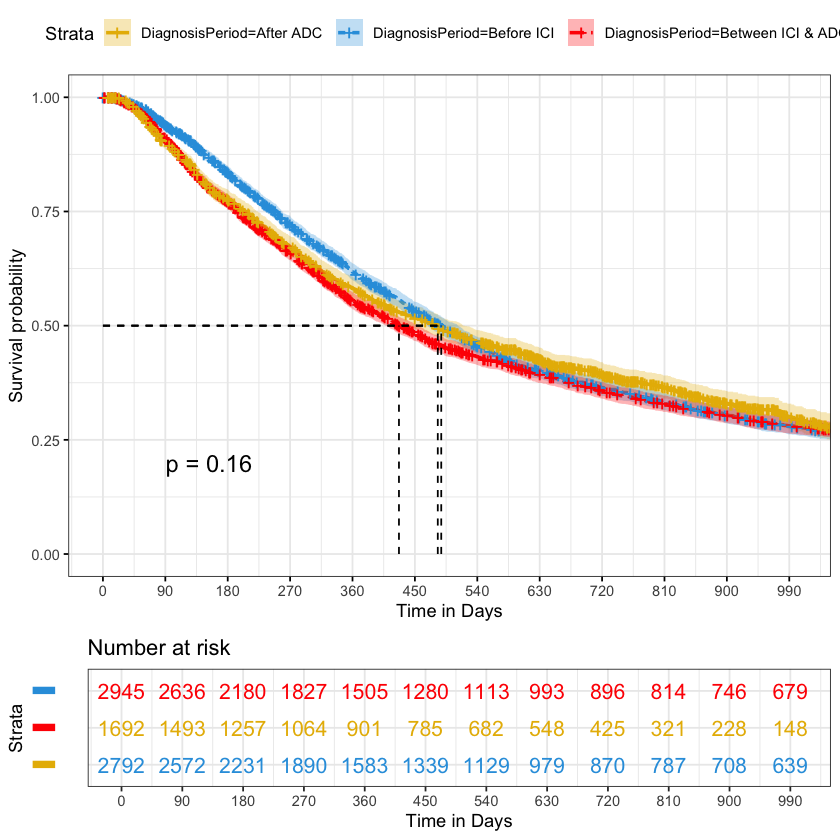

In [48]:
ggsurvplot(fit = fit2,
           data = dd,
           xlim = c(0, 1000),
           break.time.by = 90,
           pval = TRUE,
           conf.int = TRUE,
           risk.table = TRUE, # Add risk table
           risk.table.col = "strata", # Change risk table color by groups
           linetype = "strata", # Change line type by groups
           surv.median.line = "hv", # Specify median survival
           ggtheme = theme_bw(), # Change ggplot2 theme
           palette = c("#E7B800", "#2E9FDF", "red"),
           risk.table.y.text = FALSE,
           xlab = "Time in Days")

## 4. Inverse propensity score weighting without imputation

In [53]:
covs <- subset(dd,
               select = c(Gender, Race, StageAtDiagnosis, AgeAtDiagnosis, EcogValue,
                          SmokingHistory, Location, Insurance, PracticeType, PrimarySite,
                          Surgery, Chemotherapy, Immunotherapy, AntibodyConjugate,
                          AdvancedDiagnosisYear, DiagnosisPeriod, AdvancedDiagnosisDate,
                          SESIndex2015_2019, PDL1, FGFR, Elixhauser,
                          DeathCensorDate, Death))
covs$Surgery <- as.integer(covs$Surgery)
covs$Chemotherapy <- as.integer(covs$Chemotherapy)
covs$Immunotherapy <- as.integer(covs$Immunotherapy)
covs$AntibodyConjugate <- as.integer(covs$AntibodyConjugate)
covs$SmokingHistory <- as.integer(covs$SmokingHistory)
covs$AdvancedDiagnosisYear <- as.factor(covs$AdvancedDiagnosisYear)
covs$PDL1 <- as.integer(covs$PDL1)
covs$FGFR <- as.integer(covs$FGFR)

# no imputation, missing is a category
# only includes baseline characteristics
# twang also tries to balance missing proportion
library(twang)
ipw <- mnps(DiagnosisPeriod ~ Gender + Race + StageAtDiagnosis + AgeAtDiagnosis +
              EcogValue + SmokingHistory + Location + Insurance + PracticeType +
              PrimarySite + SESIndex2015_2019 + PDL1 + FGFR + Elixhauser,
            data = covs,
            stop.method = "es.max",
            n.trees = 5000)

To reproduce results from prior versions of the twang package, please see the version="legacy" option described in the documentation.



Fitting boosted model
Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3194             nan     0.0100       nan
     2        1.3149             nan     0.0100       nan
     3        1.3105             nan     0.0100       nan
     4        1.3061             nan     0.0100       nan
     5        1.3019             nan     0.0100       nan
     6        1.2977             nan     0.0100       nan
     7        1.2937             nan     0.0100       nan
     8        1.2897             nan     0.0100       nan
     9        1.2858             nan     0.0100       nan
    10        1.2819             nan     0.0100       nan
    20        1.2474             nan     0.0100       nan
    40        1.1950             nan     0.0100       nan
    60        1.1579             nan     0.0100       nan
    80        1.1312             nan     0.0100       nan
   100        1.1117             nan     0.0100       nan
   120        1.0973             nan     0.0100   

In [55]:
wts <- get.weights(ipw)
tab <- cobalt::bal.tab(ipw, stats = "mean.diffs", thresholds = c(m = .1), un = TRUE)
print(tab)

Warning message:
"Missing values exist in the covariates. Displayed values omit these observations."


Balance summary across all treatment pairs
                                     Type Max.Diff.Un Max.Diff.Adj
Gender_M                           Binary      0.0367       0.0068
Gender:<NA>                        Binary      0.0004       0.0004
Race_Black or African American     Binary      0.0022       0.0084
Race_Other Race                    Binary      0.0469       0.0232
Race_White                         Binary      0.0456       0.0225
Race:<NA>                          Binary      0.0620       0.0094
StageAtDiagnosis_Stage0            Binary      0.0047       0.0013
StageAtDiagnosis_Stage1            Binary      0.0082       0.0076
StageAtDiagnosis_Stage2            Binary      0.0873       0.0247
StageAtDiagnosis_Stage3            Binary      0.1165       0.0253
StageAtDiagnosis_Stage4            Binary      0.2060       0.0395
StageAtDiagnosis:<NA>              Binary      0.0677       0.0328
AgeAtDiagnosis                    Contin.      0.1846       0.0656
EcogValue          

## 5. Inverse propensity score weighting with imputation